    フィルタリングモジュール
    フィルタリング前後評価モジュール

In [1]:
import numpy as np
import matplotlib.pyplot as plt

wavelength=np.load("../wavelength_196.npy")[:150]
HSI_raw_datacube=np.load('../trim_overlapped_A_all_float32_all.npy')[:,:,:,:150]
c_raw_datacube=np.float16(np.load('../c_overlapped_all.npy'))

print(wavelength.shape)
print(HSI_raw_datacube.shape) # (n, y, x, wl)
print(c_raw_datacube.shape)

(150,)
(410, 40, 200, 150)
(410,)


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pywt
from scipy.stats import median_abs_deviation

def get_outlier_maskcube(HSI_raw_datacube):
    aa,bb,cc,dd=HSI_raw_datacube.shape
    average_spec_all=np.average(HSI_raw_datacube.reshape(aa,bb*cc,dd),axis=1)
    
    std_1 =np.std(average_spec_all,axis=0)
    std_3=std_1.copy()*3
    aver_of_average_spec_all = np.average(average_spec_all,axis=0)
    
    up_board = (aver_of_average_spec_all+std_3).copy()
    down_board = (aver_of_average_spec_all-std_3).copy()
    
    outlier_maskcube=np.zeros_like(HSI_raw_datacube,dtype=np.uint8)
    for wl in range(outlier_maskcube.shape[-1]):
        print(f'Process {wl+1} in {dd} ...',end='\r')
        where_up_outlier = np.where(HSI_raw_datacube[:,:,:,wl] > up_board[wl])
        where_down_outlier = np.where(HSI_raw_datacube[:,:,:,wl] < down_board[wl])
        one_mask=np.zeros_like(HSI_raw_datacube[:,:,:,wl],dtype=np.uint8)
        one_mask[where_up_outlier] = 1
        one_mask[where_down_outlier] = 1
        outlier_maskcube[:,:,:,wl] = one_mask.copy()
    print('\nDone.')
    print(f'outlier_maskcube shape: {outlier_maskcube.shape}')
    
    aa,bb,cc,dd=HSI_raw_datacube.shape
    all_pixels_count = aa*bb*cc*dd
    outlier_pixels_count = np.where(outlier_maskcube==1)[0].shape[0]
    print('='*80+f'\nOutlier rate = {100*(outlier_pixels_count/all_pixels_count)}% ({outlier_pixels_count} in all {all_pixels_count}).\n'+'='*80)

    return outlier_maskcube

def Filtering_on_each_wl_img(img, mask, show_detail):
    
    fontsize=14

    mask=cv2.dilate(mask.copy(),np.ones((3,3),np.uint8)).copy()
    
    denoised_img = img.copy()
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    for i in range(0, len(contours)):
        mask_each=np.zeros_like(mask,np.uint8)
        cv2.drawContours(image=mask_each, contours=contours, contourIdx=i, color=(1), thickness=-1, hierarchy=hierarchy)
        #plt.imshow(mask_each)
        #plt.title(f'mask_each {i+1} in {len(contours)}')
        #plt.show()
        surround=cv2.dilate(mask_each.copy(),np.ones((3,3),np.uint8))-mask_each
        #plt.imshow(surround)
        #plt.title('surround')
        #plt.show()
        # 外れ値の補正
        denoised_img[np.where(mask_each==1)] = np.median(img[np.where(surround==1)])
        #plt.imshow(denoised_img,cmap='gray')
        #plt.title(f'denoised_img {i+1} in {len(contours)}')
        #plt.show()
    
    if show_detail:
        plt.imshow(denoised_img,cmap='gray')
        plt.title('denoised_img')
        #plt.savefig(f'img for paper/5-3.tif',dpi=300,bbox_inches='tight')
        plt.show()
    
    # 2D Wavelet変換によるノイズ除去
    coeffs = pywt.wavedec2(denoised_img, 'db2', level=2)
    
    if show_detail:
        cA, (cH, cV, cD), (cH2, cV2, cD2) = coeffs
    
        plt.figure(figsize=(20,4))
        plt.subplot(241)
        plt.imshow(cA,cmap='gray')
        plt.title('cA',fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)

        plt.subplot(242)
        plt.imshow(cH,cmap='gray')
        plt.title('cH',fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)

        plt.subplot(243)
        plt.imshow(cV,cmap='gray')
        plt.title('cV',fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)

        plt.subplot(244)
        plt.imshow(cD,cmap='gray')
        plt.title('cD',fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)

        
        plt.subplot(246)
        plt.imshow(cH2,cmap='gray')
        plt.title('cH2',fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        
        plt.subplot(247)
        plt.imshow(cV2,cmap='gray')
        plt.title('cV2',fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        
        plt.subplot(248)
        plt.imshow(cD2,cmap='gray')
        plt.title('cD',fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
    
        plt.tight_layout()
        plt.show()

    detail_coeff = np.concatenate([c.ravel() for c in coeffs[-1]], axis=0)
    threshold = 3 * median_abs_deviation(detail_coeff)
    
    denoised_coeffs = []
    for coeff in coeffs:
        if isinstance(coeff, tuple):
            denoised_detail = [(cv.ravel() * (np.abs(cv.ravel()) <= threshold)).reshape(cv.shape) for cv in coeff]
            denoised_coeffs.append(denoised_detail)
        else:
            denoised_coeffs.append(coeff)
    
    if show_detail:
        cA, (cH, cV, cD), (cH2, cV2, cD2) = denoised_coeffs#[:2]
    
        plt.figure(figsize=(20,4))
        plt.subplot(241)
        plt.imshow(cA,cmap='gray')
        plt.title('cA',fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        #plt.colorbar()
        #plt.show()
        
        plt.subplot(242)
        plt.imshow(cH,cmap='gray')
        plt.title('denoised_cH',fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)

        plt.subplot(243)
        plt.imshow(cV,cmap='gray')
        plt.title('denoised_cV',fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)

        plt.subplot(244)
        plt.imshow(cD,cmap='gray')
        plt.title('denoised_cD',fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        
        plt.subplot(246)
        plt.imshow(cH2,cmap='gray')
        plt.title('denoised_cH2',fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)

        plt.subplot(247)
        plt.imshow(cV2,cmap='gray')
        plt.title('denoised_cV2',fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)

        plt.subplot(248)
        plt.imshow(cD2,cmap='gray')
        plt.title('denoised_cD',fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
    
        plt.tight_layout()
        plt.show()
    
    
    # 逆変換による画像の再構成
    final_img = pywt.waverec2(denoised_coeffs, 'db2')
    if show_detail:
        plt.imshow(final_img,cmap='gray')
        plt.title('final_img')
        plt.show()
    
        print(f'img mean = {np.average(img)}')
        print(f'final_img mean = {np.average(final_img)}')
        print(f'img sd = {np.std(img)}')
        print(f'final_img sd = {np.std(final_img)}')
        
        plt.boxplot([img.flatten(),final_img.flatten()])
        plt.xticks([1,2],['Before','After'])
        plt.title('Data distribution before / after filtering')
        plt.show()
    return final_img

def Process_Filtering(HSI_raw_datacube):
    if not os.path.exists('Filtered_datacube_MAD.npy'):
        outlier_maskcube = get_outlier_maskcube(HSI_raw_datacube)

        aa,bb,cc,dd = HSI_raw_datacube.shape
        Filtered_datacube = np.zeros_like(HSI_raw_datacube, dtype=np.float32)
        for i in range(aa):
            for wl in range(dd):
                print(f'Process Sample No.{i+1} in {aa}, Wavelength No.{wl+1} in {dd}',end='\r')
                mask = outlier_maskcube[i,:,:,wl].copy()
                img = HSI_raw_datacube[i,:,:,wl].copy()
                final_img = Filtering_on_each_wl_img(img=img, mask=mask, show_detail=False)
                if final_img.shape == (bb,cc):
                    Filtered_datacube[i,:,:,wl] = final_img.copy()
                else:
                    Filtered_datacube[i,:,:,wl] = final_img[:bb,:cc].copy()
        print('\nDone !')
        np.save('Filtered_datacube_MAD.npy',Filtered_datacube,fix_imports=True)
        print(Filtered_datacube.shape)
    else:
        Filtered_datacube = np.load('Filtered_datacube_MAD.npy')
        print(Filtered_datacube.shape)

    return Filtered_datacube

In [3]:
if __name__ == '__main__':
    Filtered_datacube = Process_Filtering(HSI_raw_datacube)

Process 150 in 150 ...
Done.
outlier_maskcube shape: (410, 40, 200, 150)
Outlier rate = 3.8499922764227645% (18941962 in all 492000000).
Process Sample No.410 in 410, Wavelength No.150 in 150
Done !
(410, 40, 200, 150)


In [10]:
def Analyse_All_pixels_each_wl_with_3xSD(datacube,title=''):
    aa,bb,cc,dd=datacube.shape
    average_spec_all=np.average(datacube.reshape(aa,bb*cc,dd),axis=1)
        
    fontsize=26
    
    std_1 =np.std(average_spec_all,axis=0)
    std_3=std_1.copy()*3
    aver_of_average_spec_all = np.average(average_spec_all,axis=0)
    
    plt.figure(figsize=(30,12))
    plt.boxplot(datacube.reshape(-1,datacube.shape[-1]))
    #aver_of_average_spec_all = np.average(average_spec_all,axis=0)
    plt.plot(aver_of_average_spec_all,c='k',label='average of average_spec_all')
    plt.plot(aver_of_average_spec_all+std_1[:],c='gray',label='± 1 * sd of average_spec_all')
    plt.plot(aver_of_average_spec_all-std_1[:],c='gray')
    plt.plot(aver_of_average_spec_all+std_3[:],c='r',label='± 3 * sd of average_spec_all')
    plt.plot(aver_of_average_spec_all-std_3[:],c='r')
    plt.xticks(np.arange(0,len(wavelength),20),[f"{i} nm" for i in wavelength[np.arange(0,len(wavelength),20)]],rotation=0,fontsize=fontsize)
    plt.legend(fontsize=fontsize,loc='upper left')
    plt.yticks(fontsize=fontsize)
    if title != '':
        plt.title(title,fontsize=fontsize)
    plt.show()

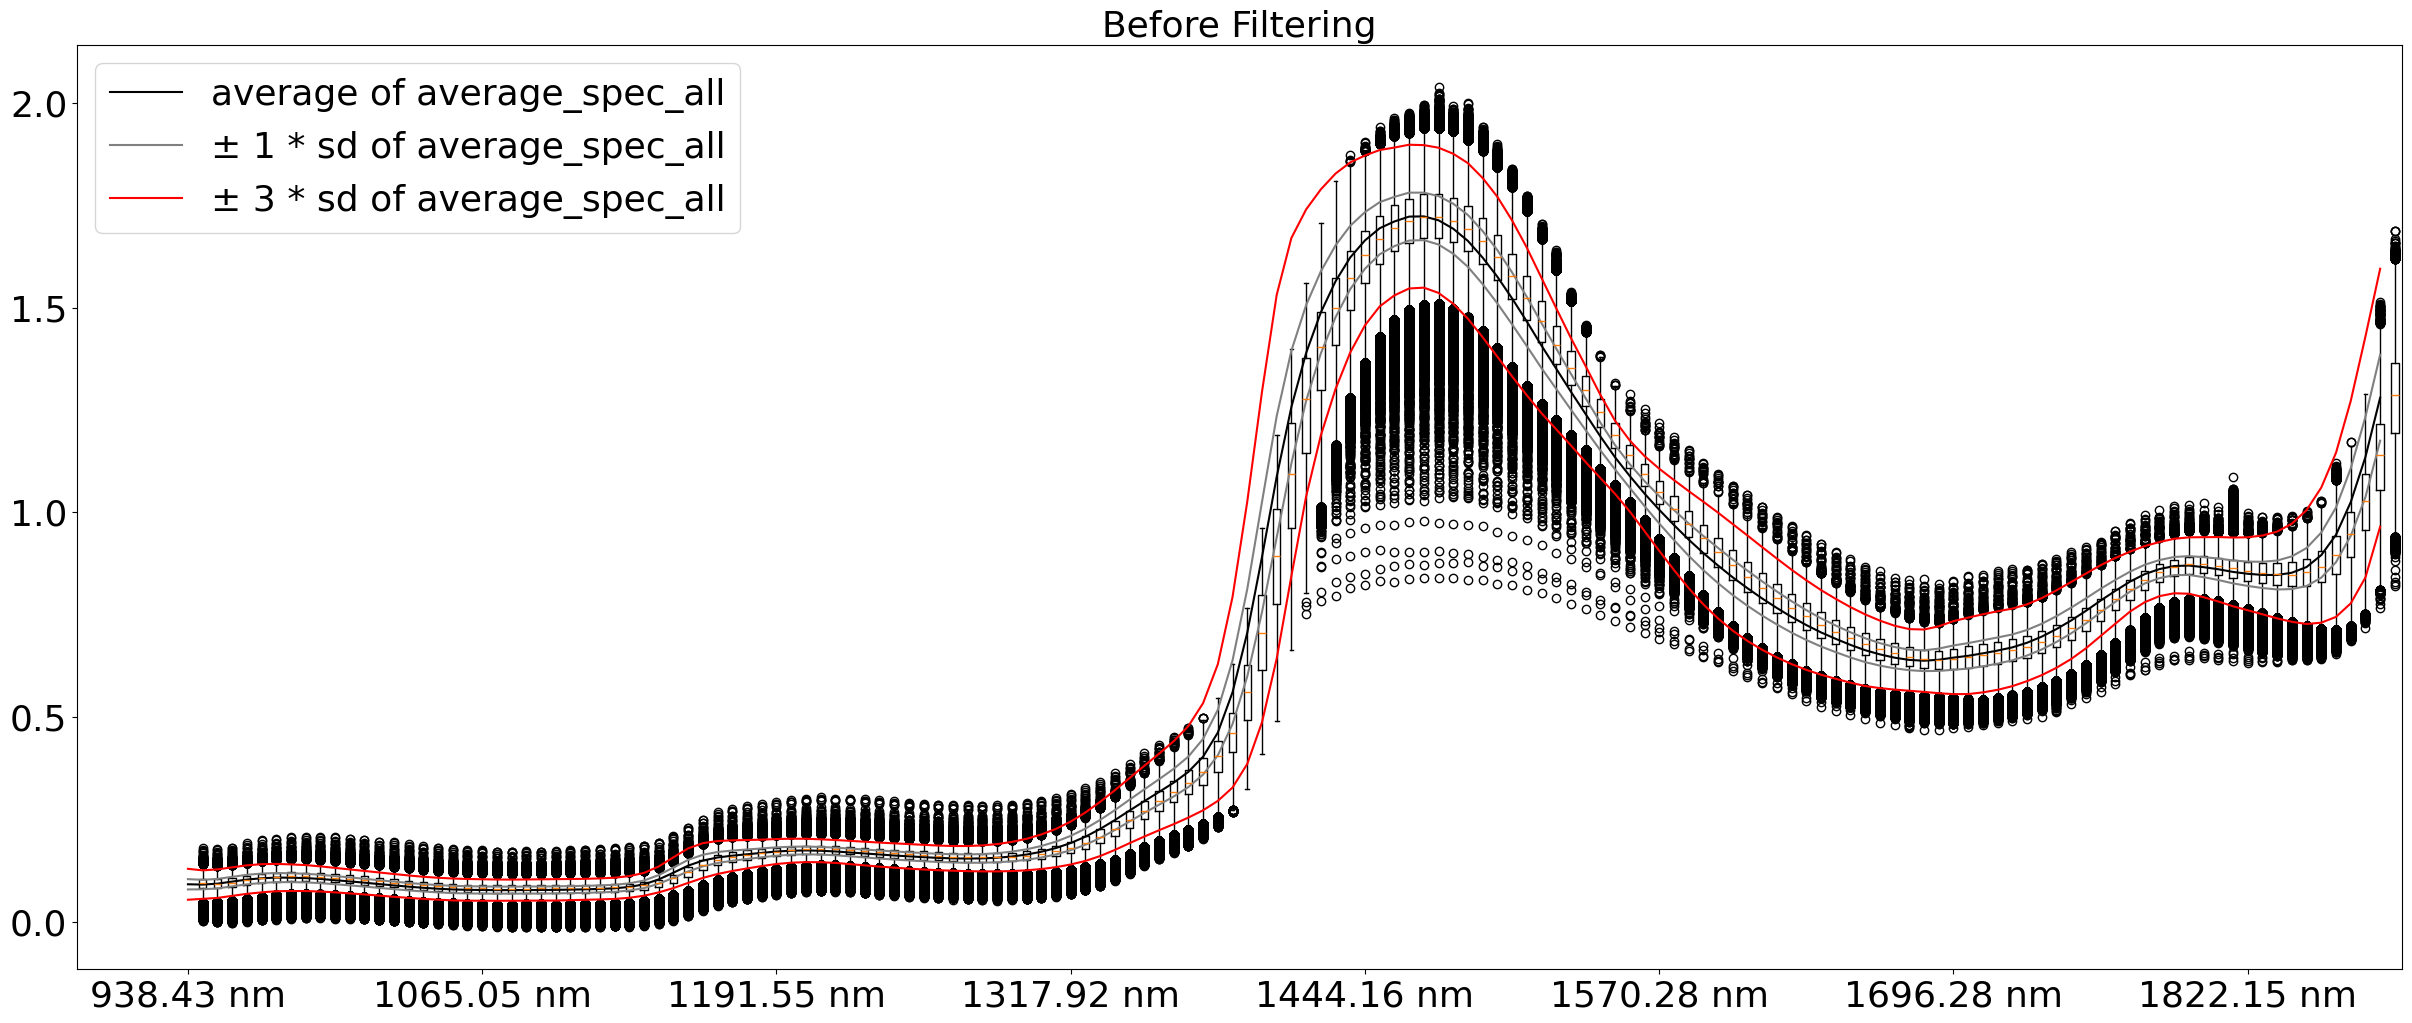

In [11]:
Analyse_All_pixels_each_wl_with_3xSD(HSI_raw_datacube, 'Before Filtering')

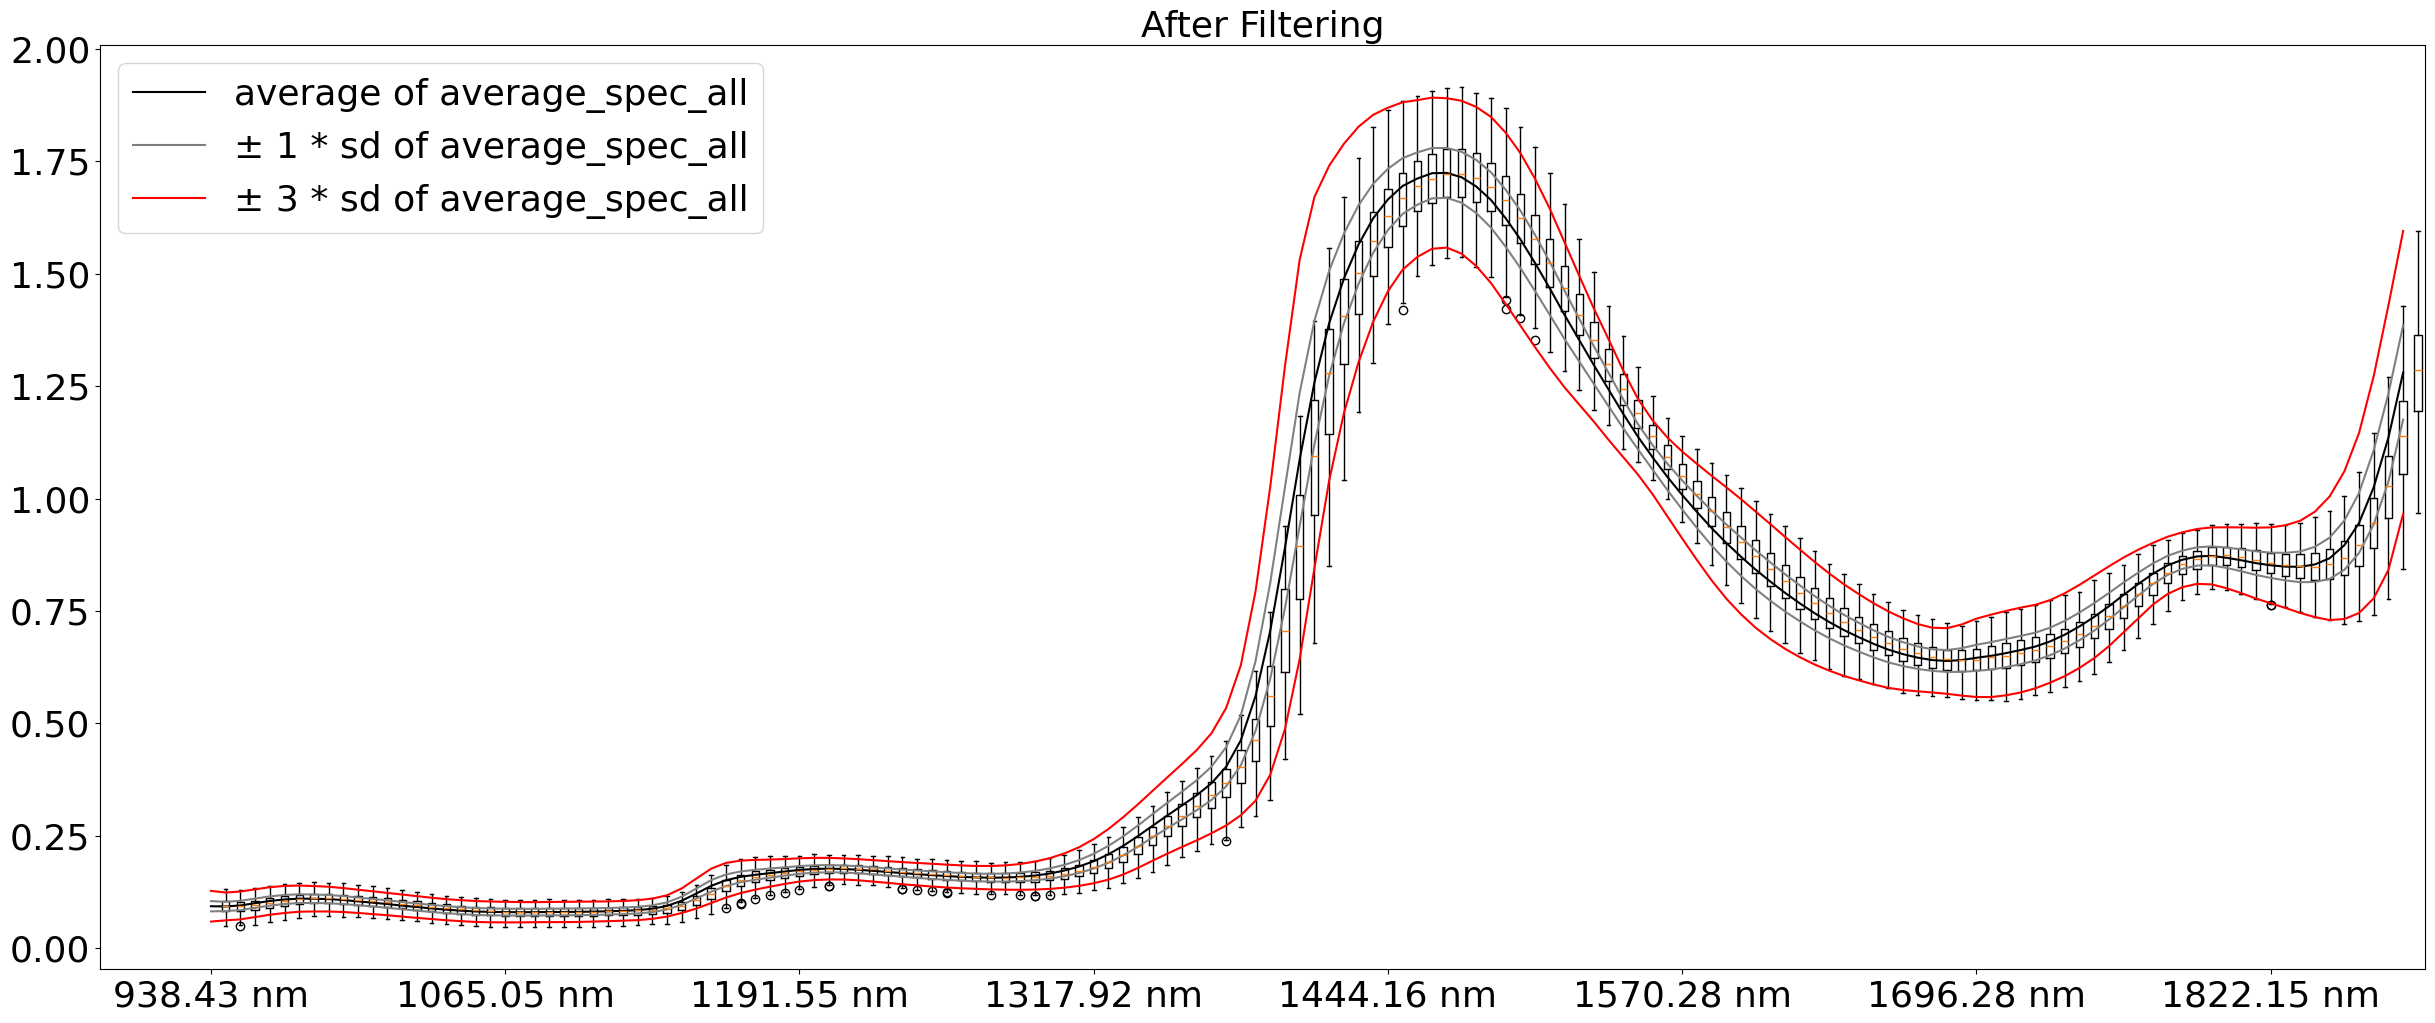

In [12]:
Analyse_All_pixels_each_wl_with_3xSD(Filtered_datacube, 'After Filtering')

In [24]:
from sklearn.decomposition import PCA

def Analyse_Principal_image_of_one_sample_use_PCA(datacube, sample_no, n_components, return_clim_list,  use_the_clim_list = ''):
    aa,bb,cc,dd=datacube.shape
    average_spec_all=np.average(datacube.reshape(aa,bb*cc,dd),axis=1)
    
    assert sample_no < aa, f'sample_no must be smaller than samples number, get {sample_no} but should be < {aa}.'
    
    dataset = average_spec_all.copy()
    pca=PCA(n_components=n_components)
    pca.fit(dataset)
    feature=pca.transform(dataset)
    loading=pca.components_
    explained_variance_ratio=pca.explained_variance_ratio_*100
    print(feature.shape,loading.shape)
    
    y = np.add.accumulate(pca.explained_variance_ratio_)
    x = np.arange(y.size)+1
    plt.figure(figsize=(20,5))
    plt.plot(x, y, ls='-', marker='o',c='k')
    plt.show()
    
    plt.figure(figsize=(20,5))
    plt.plot(dataset.T)
    plt.title(f"dataset Scpectrum",fontsize=16)
    plt.grid()
    plt.show()
    
    for i in range(feature.shape[-1]):
        plt.figure(figsize=(20,5))
        plt.plot(loading[i])
        plt.title(f"PC{i+1} loading",fontsize=16)
        plt.grid()
        plt.show()
    
    pca_transformed_all_pixel=pca.transform(datacube.reshape(aa*bb*cc,dd)).reshape(aa,bb,cc,-1)    

    if use_the_clim_list == '':
        clim_list=[]
        plt.figure(figsize=(10,8))
        for pc_no in range(4):
            explain_=str(round(pca.explained_variance_ratio_[pc_no]*100,4))
            one_pc_all_pixel=pca_transformed_all_pixel[:,:,:,pc_no]
            img = one_pc_all_pixel[sample_no].copy()   
            plt.subplot(n_components,1,pc_no+1)
            plt.imshow(img,cmap='gray')
            plt.title(f'Transformed image on PC{pc_no+1} loading,\nSample No.{sample_no+1}, Explain {explain_}%')
            clim_list.append(np.array([img.min(),img.max()]))
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(10,8))
        for pc_no in range(4):
            explain_=str(round(pca.explained_variance_ratio_[pc_no]*100,4))
            one_pc_all_pixel=pca_transformed_all_pixel[:,:,:,pc_no]
            img = one_pc_all_pixel[sample_no].copy()   
            plt.subplot(n_components,1,pc_no+1)
            plt.imshow(img,cmap='gray')
            plt.title(f'Transformed image on PC{pc_no+1} loading,\nSample No.{sample_no+1}, Explain {explain_}%')
            plt.clim(use_the_clim_list[pc_no])
        plt.tight_layout()
        plt.show()

    if return_clim_list:
        return clim_list

(410, 5) (5, 150)


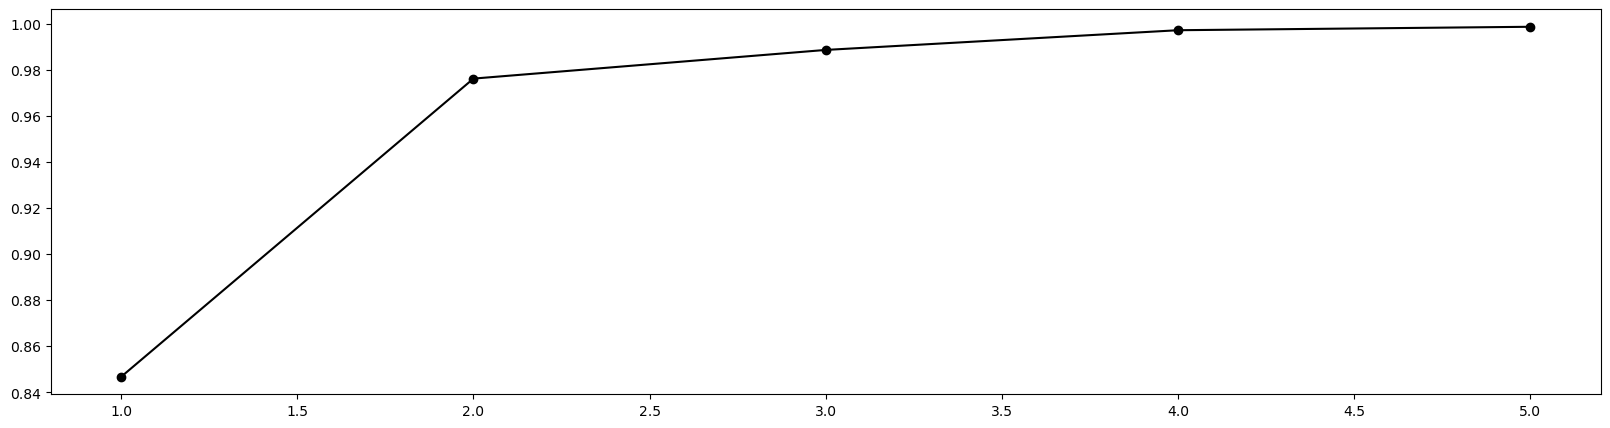

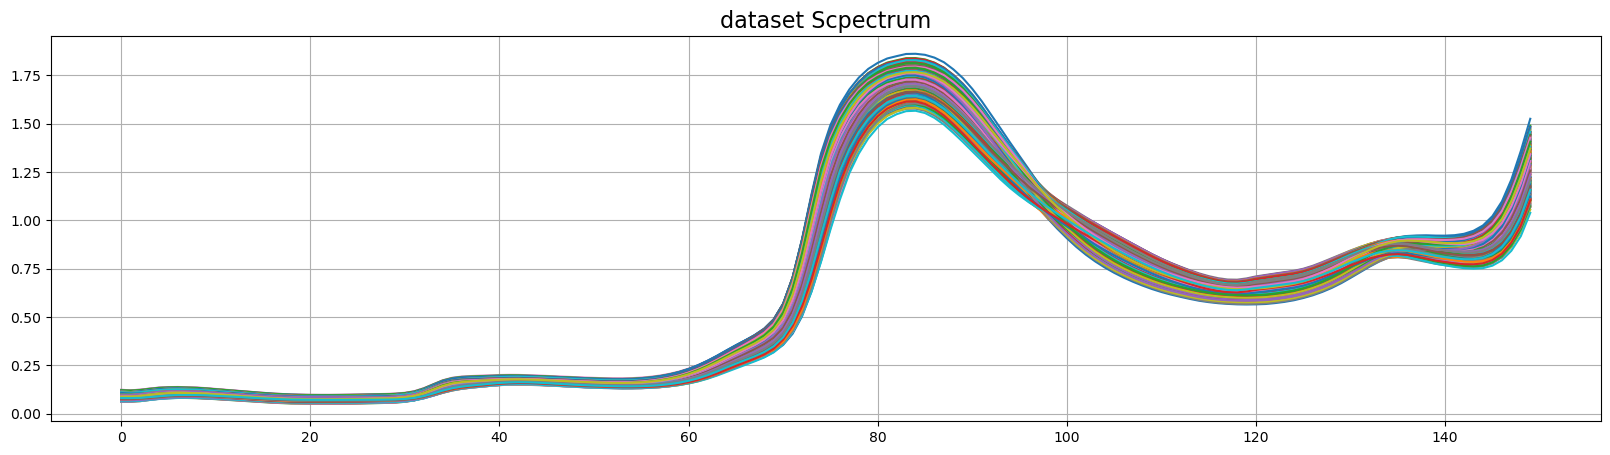

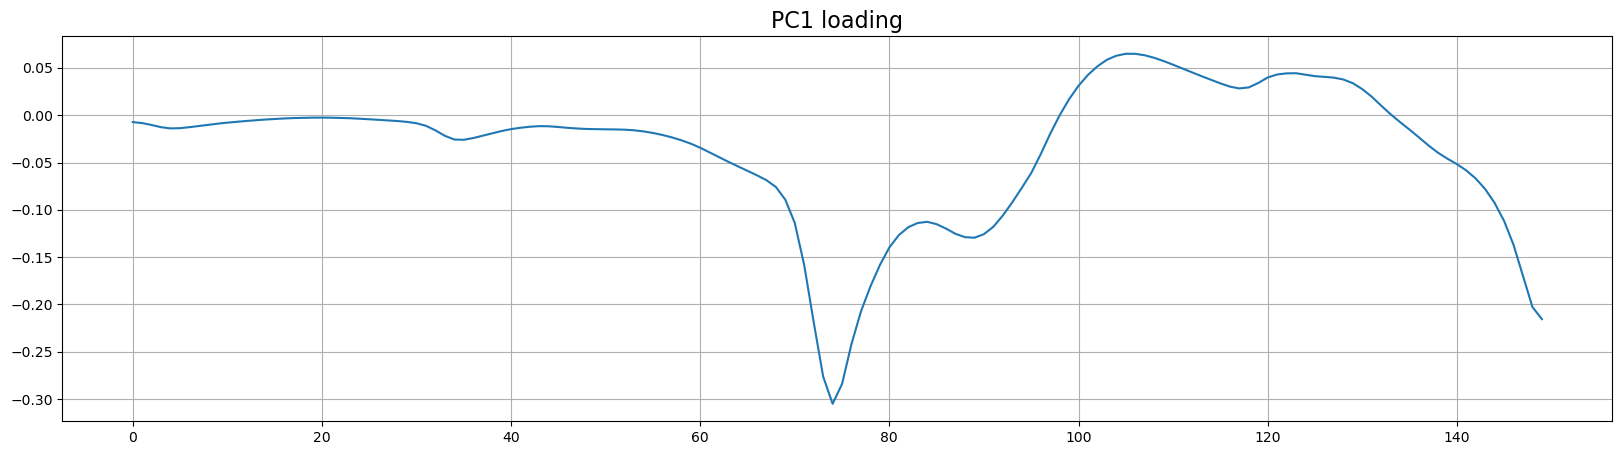

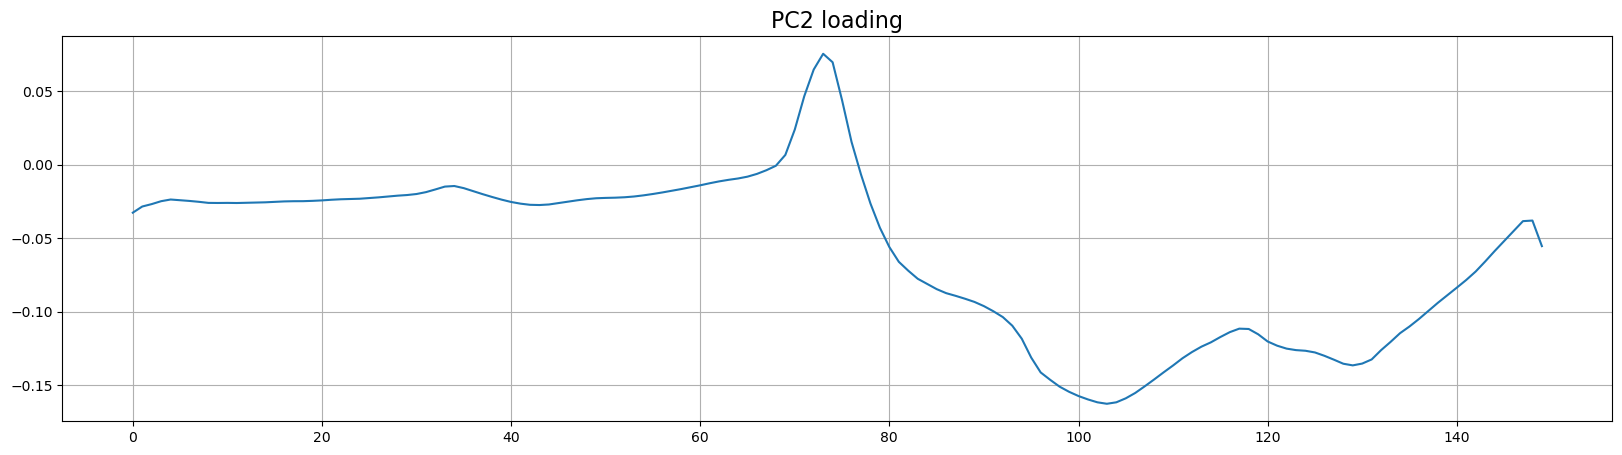

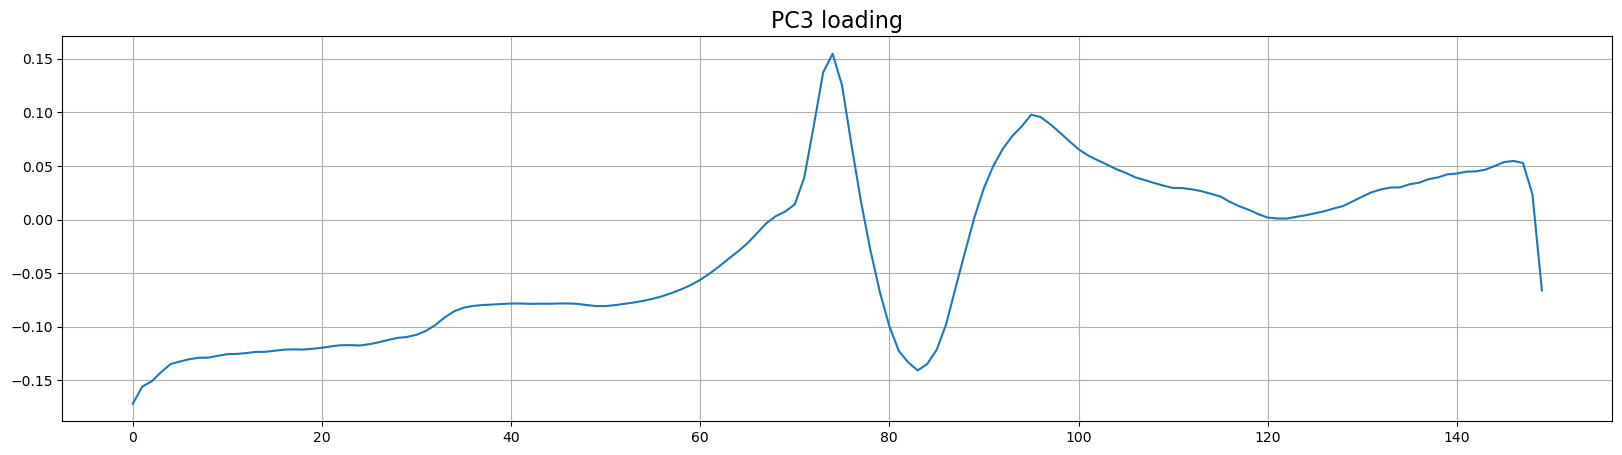

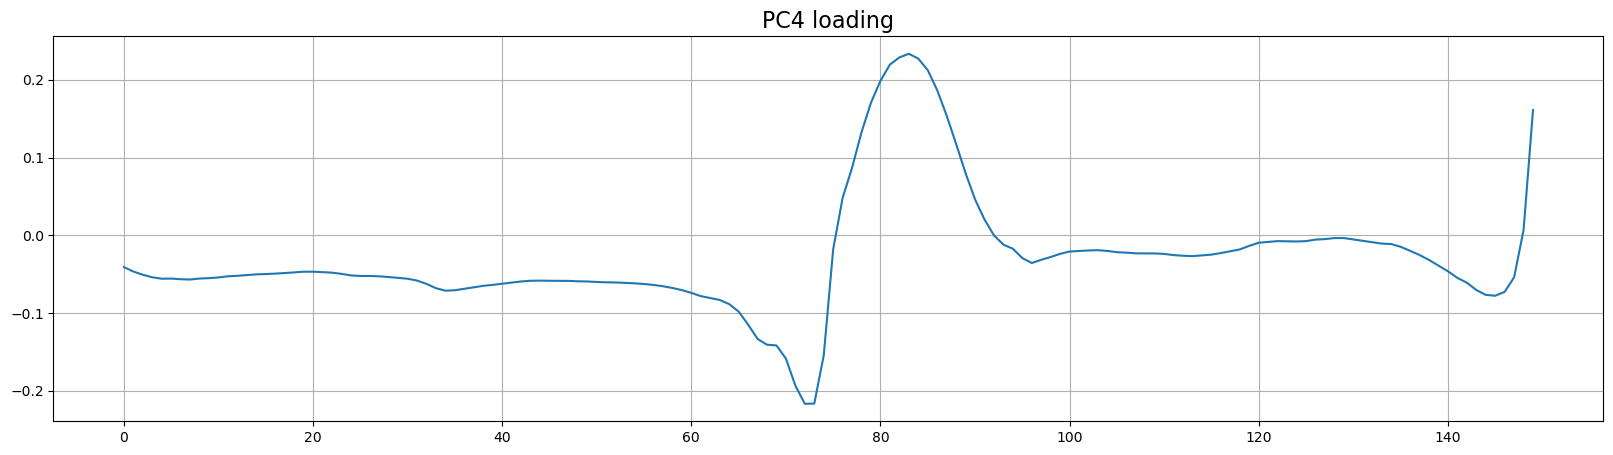

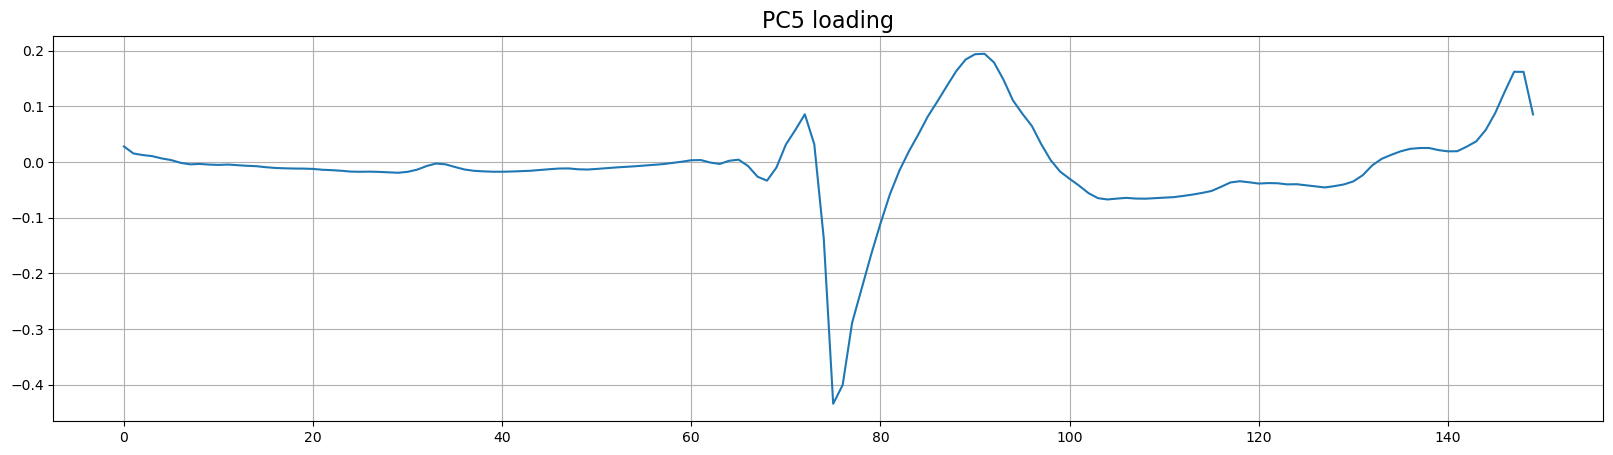

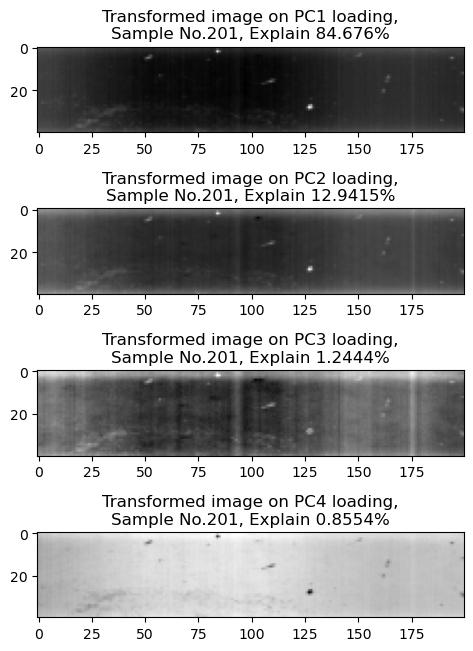

In [25]:
clim_list = Analyse_Principal_image_of_one_sample_use_PCA(HSI_raw_datacube, sample_no=200, n_components=5, return_clim_list=True)

(410, 5) (5, 150)


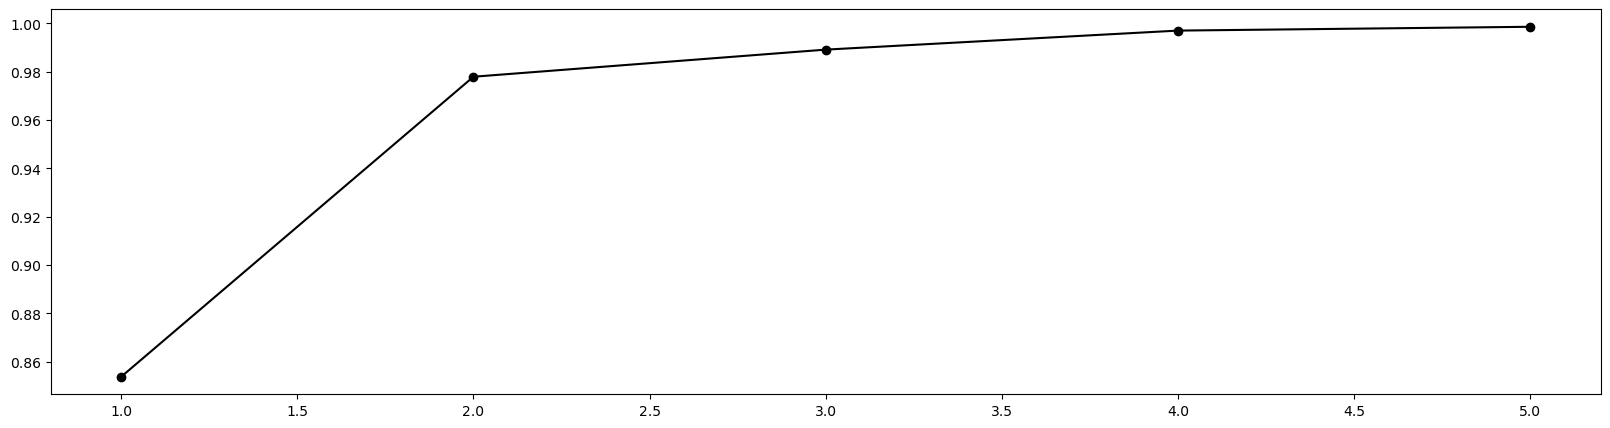

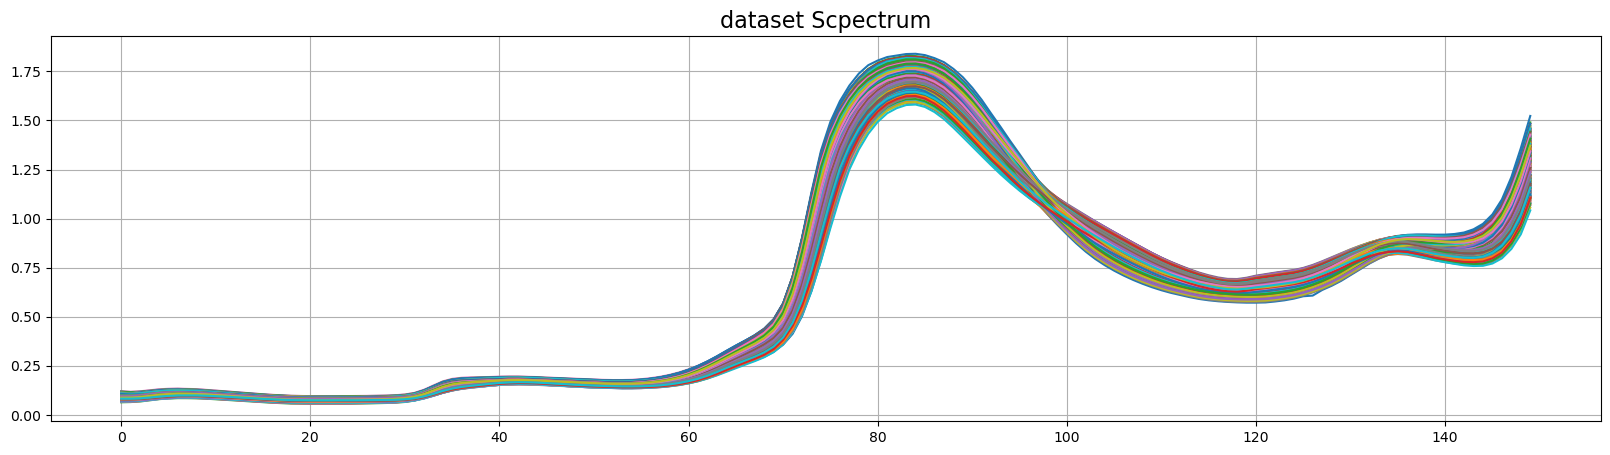

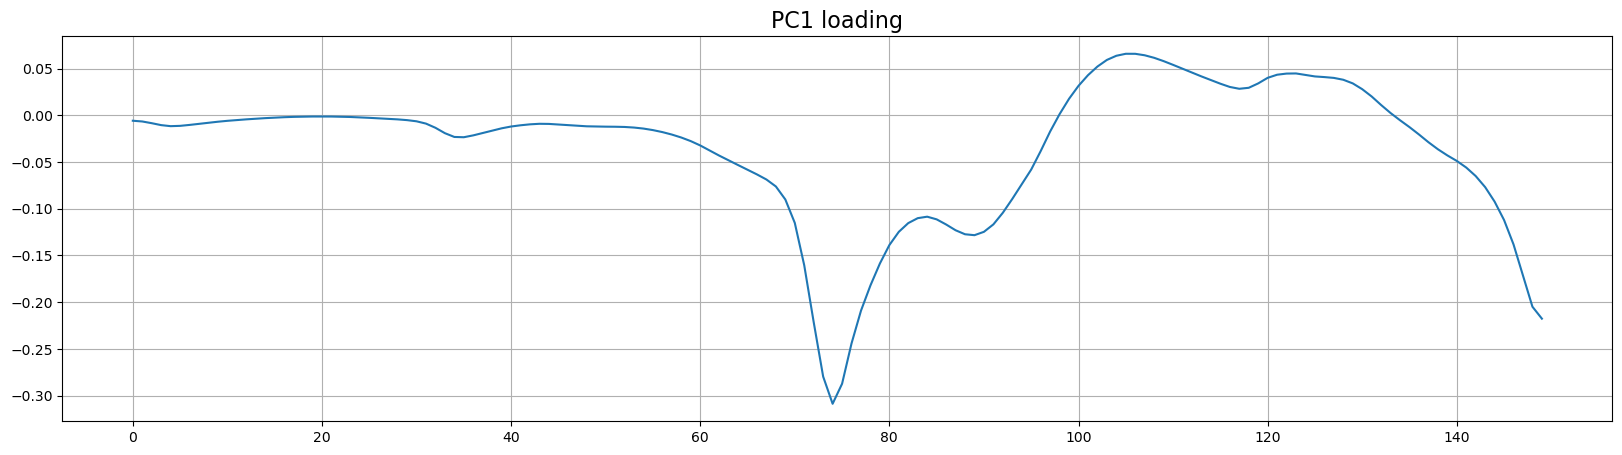

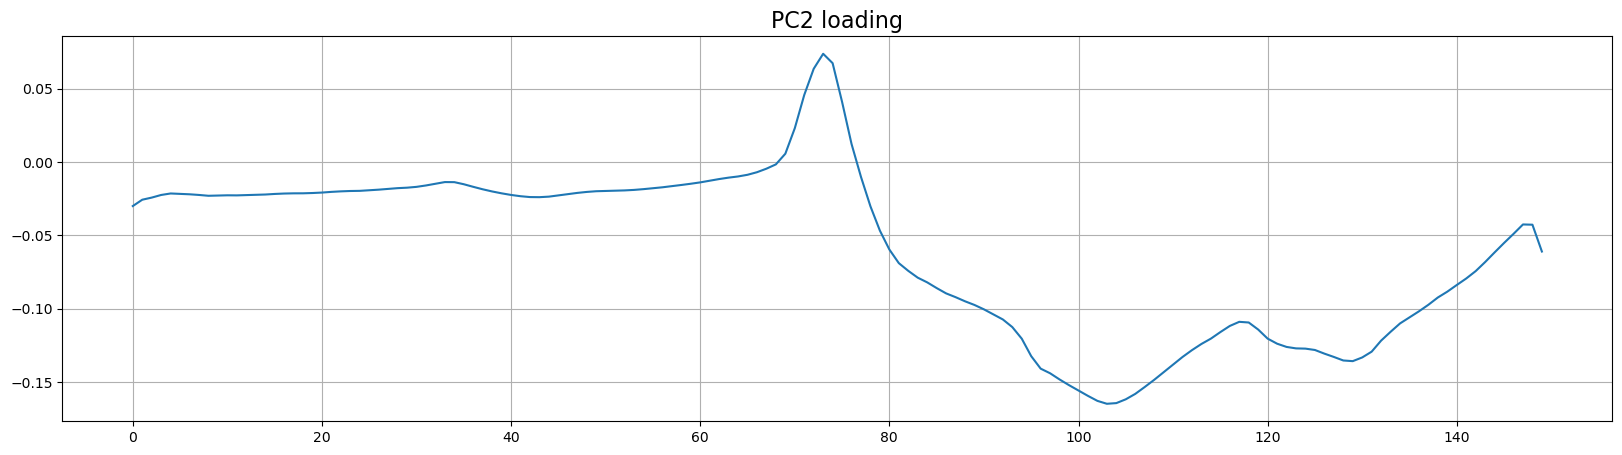

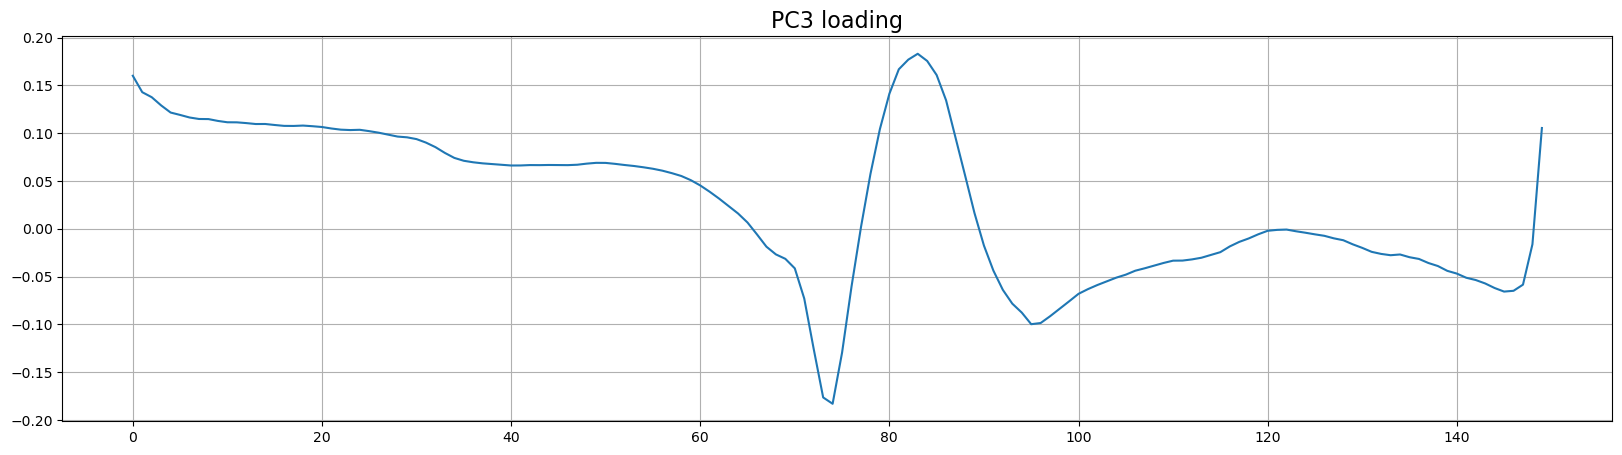

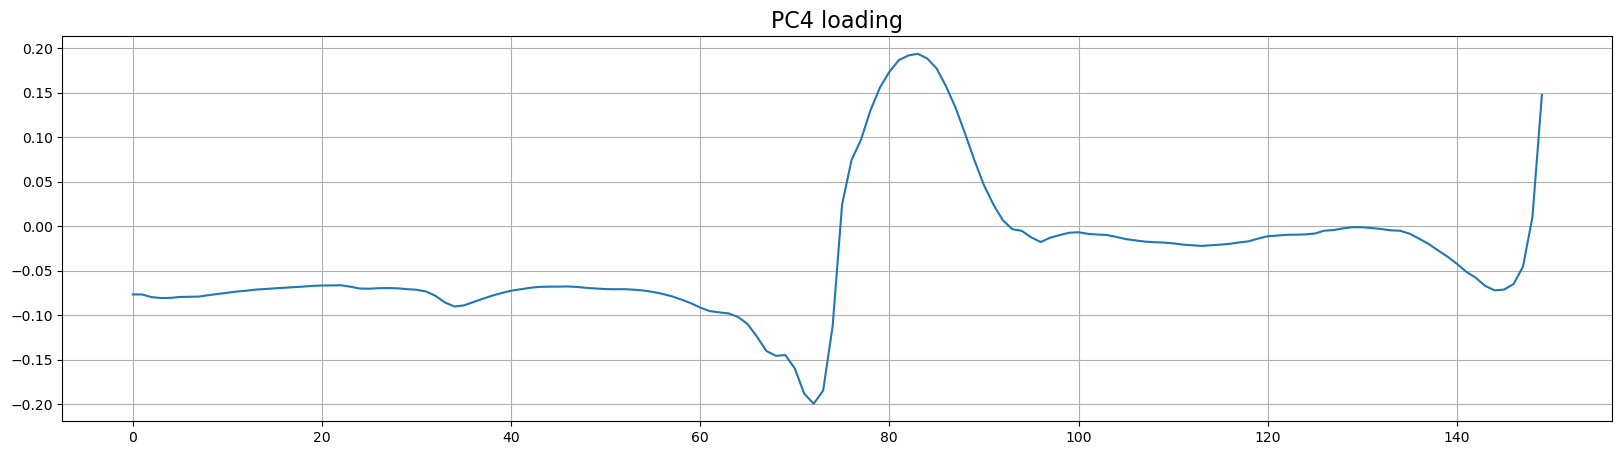

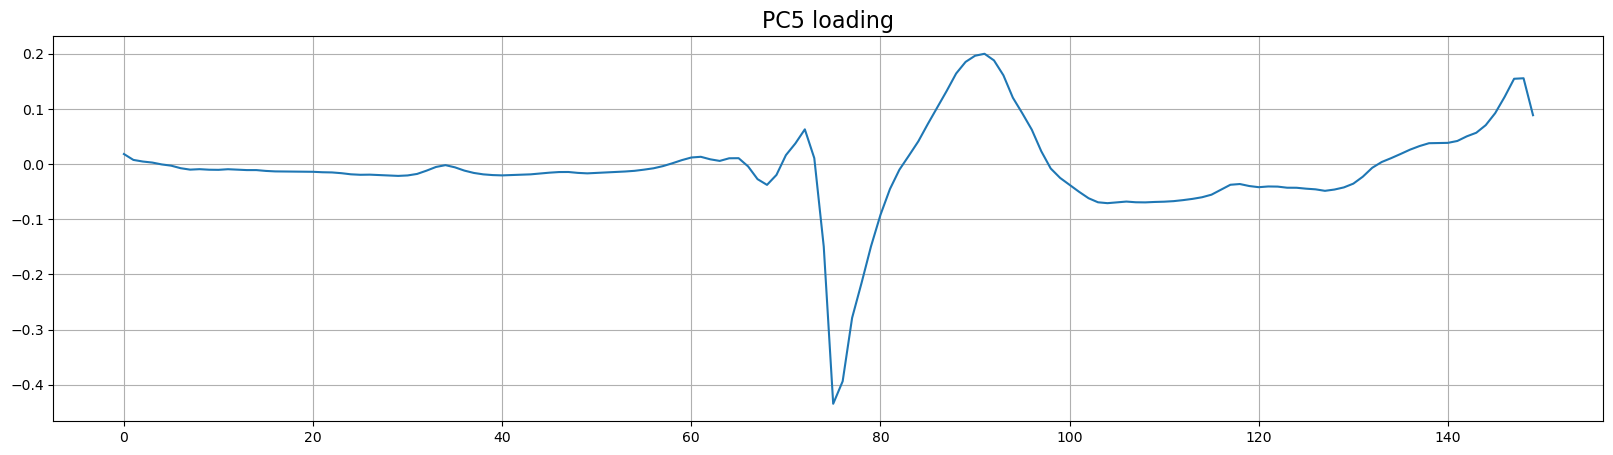

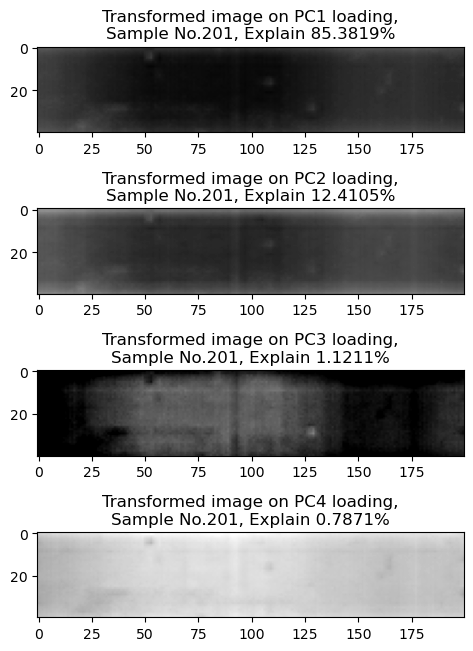

In [26]:
Analyse_Principal_image_of_one_sample_use_PCA(Filtered_datacube, sample_no=200, n_components=5, return_clim_list=False, use_the_clim_list=clim_list)

In [40]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
    
def Analyse_calculate_LOD_min_max_for_each_pixel(HSI_datacube, c_datacube):
    aa,bb,cc,dd=HSI_datacube.shape
    average_spec_all=np.average(HSI_datacube.reshape(aa,bb*cc,dd),axis=1)

    x_train=average_spec_all.copy()
    y_train=c_datacube.copy()
    
    print("x_train : ",x_train.shape)
    print("y_train : ",y_train.shape)
    
    n_components=3
    pls_model=PLSRegression(n_components=n_components)
    pls_model.fit(x_train,y_train)
    HSI_datacube=HSI_datacube.reshape(aa,bb*cc,dd).copy()
    
    LODmin_list=[]
    LODmax_list=[]
    for i in range(bb*cc):
        print(f'Process pixel {i+1} in all {bb*cc}...',end='\r')
        x_train=HSI_datacube[:,i,:].copy()
        
        SEN = 1/np.linalg.norm(pls_model.coef_.flatten())
        
        varx = np.average(np.var(x_train,axis=0))
        
        varycal = np.var(y_train)
        
        ybarcal=np.average(y_train)
        
        h0min = np.square(np.average(y_train))/np.sum((y_train-np.average(y_train))**2)
        
        T = pls_model.transform(x_train)[:,0].reshape(-1,1)
        
        TTT=np.dot(T.T,T)
        TTT_inv=np.linalg.inv(TTT)
        
        hcal=[]
        for i in range(len(x_train)):
            h=np.dot(np.dot(T[i,0].reshape(1,-1).T, TTT_inv), T[i,0].reshape(1,-1))
            hcal.append(h)
        hcal=np.concatenate(hcal,axis=0).flatten()
        #print('hcal shape : ',hcal.shape)
        
        h0cal = hcal+h0min*(1-((y_train-np.average(y_train))/ybarcal)**2)
        
        h0max=np.max(h0cal)
        
        I=len(x_train)
        
        LODmin=3.3*(((SEN**-2)*varx + (h0min+1/I)*(SEN**-2)*varx + (h0min+1/I)*varycal)**0.5)
        LODmax=3.3*(((SEN**-2)*varx + (h0max+1/I)*(SEN**-2)*varx + (h0max+1/I)*varycal)**0.5)
        
        LODmin_list.append(LODmin)
        LODmax_list.append(LODmax)
    LODmin_list=np.array(LODmin_list).reshape(bb,cc)
    LODmax_list=np.array(LODmax_list).reshape(bb,cc)
    print('\nLODmin_list Shape:',LODmin_list.shape)
    print('LODmax_list Shape:',LODmax_list.shape)
    
    print('LODmin : ', LODmin_list)
    print('LODmax : ', LODmax_list)
    print('Average LODmin : ', np.average(LODmin_list))
    print('Average LODmax : ', np.average(LODmax_list))
    print('SD of LODmin : ', np.std(LODmin_list))
    print('SD of LODmax : ', np.std(LODmax_list))

    return LODmin_list, LODmax_list

def Analyse_Visualize_LOD_min_max_for_each_pixel(LODmin_list, LODmax_list, return_LOD_clim_list,  use_the_LODmin_clim_list = '',  use_the_LODmax_clim_list = ''):
    fontsize=16

    if use_the_LODmin_clim_list != '':
        plt.figure(figsize=(20,8))
        plt.subplot(211)
        plt.imshow(LODmin_list,cmap='gray')
        plt.colorbar(orientation='horizontal')
        plt.title('LODmin of each pixel',fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        plt.clim(use_the_LODmin_clim_list)
    else:
        plt.figure(figsize=(20,8))
        plt.subplot(211)
        plt.imshow(LODmin_list,cmap='gray')
        plt.colorbar(orientation='horizontal')
        plt.title('LODmin of each pixel',fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)

    if use_the_LODmax_clim_list != '':
        plt.subplot(212)
        plt.imshow(LODmax_list,cmap='gray')
        plt.colorbar(orientation='horizontal')
        plt.title('LODmax of each pixel',fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        plt.clim(use_the_LODmax_clim_list)
        plt.show()
    else:
        plt.subplot(212)
        plt.imshow(LODmax_list,cmap='gray')
        plt.colorbar(orientation='horizontal')
        plt.title('LODmax of each pixel',fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        plt.show()
    
    plt.figure(figsize=(20,6))
    plt.subplot(131)
    plt.boxplot([LODmin_list.flatten(),LODmax_list.flatten()])
    plt.title('Boxplot of LODmin/LODmax of each pixel',fontsize=fontsize)
    plt.xticks([1,2],['LODmin','LODmax'],fontsize=fontsize)
    plt.yticks(np.arange(LODmin_list.flatten().min(), LODmax_list.flatten().max(), (LODmax_list.flatten().max()-LODmin_list.flatten().min())/10),fontsize=fontsize)

    plt.subplot(132)
    plt.boxplot(LODmin_list.flatten())
    plt.title('Boxplot of LODmin of each pixel',fontsize=fontsize)
    plt.yticks(np.arange(LODmin_list.flatten().min(), LODmin_list.flatten().max(), (LODmin_list.flatten().max()-LODmin_list.flatten().min())/6),fontsize=fontsize)# [round(i,5) for i in np.arange(LODmin_list.flatten().min(), LODmin_list.flatten().max(), ((LODmin_list.flatten().max()-LODmin_list.flatten().min())/6))])
    plt.xticks([1],['LODmin'],fontsize=fontsize)

    plt.subplot(133)
    plt.boxplot(LODmax_list.flatten())
    plt.title('Boxplot of LODmax of each pixel',fontsize=fontsize)
    plt.yticks(np.arange(LODmax_list.flatten().min(), LODmax_list.flatten().max(), (LODmax_list.flatten().max()-LODmax_list.flatten().min())/5),fontsize=fontsize)
    plt.xticks([1],['LODmax'],fontsize=fontsize)
    plt.tight_layout()
    plt.show()

    if return_LOD_clim_list:
        return np.array([LODmin_list.min(), LODmin_list.max()]), np.array([LODmax_list.min(), LODmax_list.max()])

x_train :  (410, 150)
y_train :  (410,)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


Process pixel 8000 in all 8000...
LODmin_list Shape: (40, 200)
LODmax_list Shape: (40, 200)
LODmin :  [[0.18973806 0.1897405  0.18974093 ... 0.18973288 0.18973354 0.18973423]
 [0.18971512 0.18971581 0.18971495 ... 0.18971259 0.1897121  0.18971139]
 [0.18969852 0.18969847 0.18969797 ... 0.18969849 0.18969929 0.18969886]
 ...
 [0.18968867 0.18969057 0.18969033 ... 0.18968316 0.18968241 0.18968336]
 [0.18969694 0.18969822 0.18970033 ... 0.18969159 0.18969054 0.18969063]
 [0.18970175 0.18970229 0.18970426 ... 0.18969902 0.18969753 0.18969742]]
LODmax :  [[0.24464488 0.24423458 0.24289599 ... 0.23866546 0.23987721 0.23905595]
 [0.24500094 0.24470815 0.24414245 ... 0.24011875 0.24173025 0.24181282]
 [0.24915808 0.25002986 0.24980527 ... 0.25891559 0.26055269 0.26177376]
 ...
 [0.26956374 0.26903637 0.27229579 ... 0.29470598 0.29152496 0.29107953]
 [0.27010069 0.27058579 0.27448089 ... 0.29503443 0.29229194 0.29235384]
 [0.26135601 0.26195448 0.26084222 ... 0.26896934 0.26797909 0.26663725]]


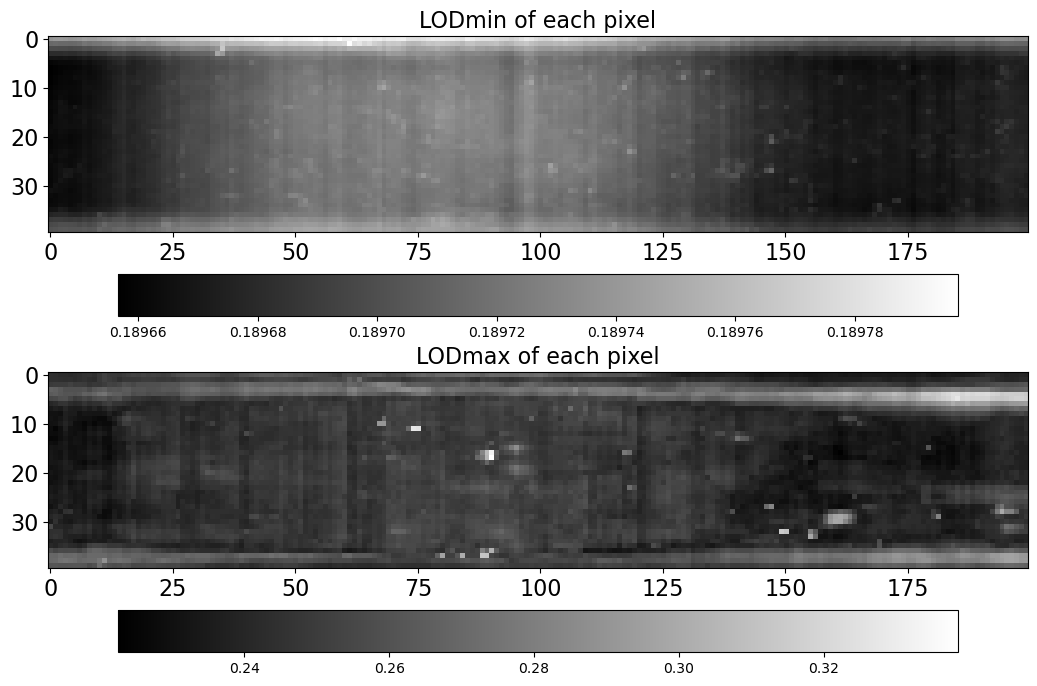

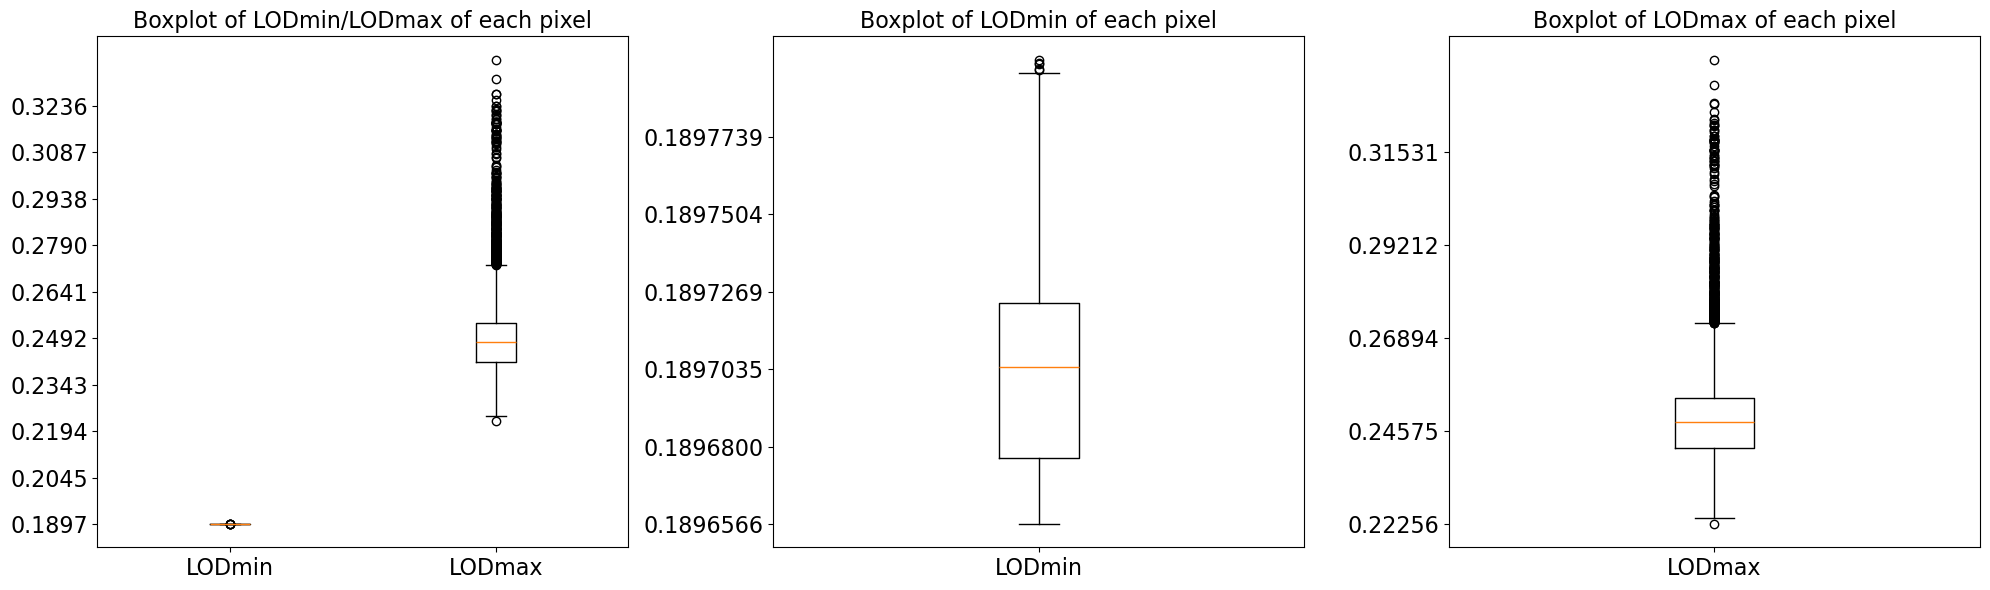

In [41]:
LODmin_list, LODmax_list = Analyse_calculate_LOD_min_max_for_each_pixel(HSI_raw_datacube, c_raw_datacube)
LODmin_clim_list, LODmax_clim_list = Analyse_Visualize_LOD_min_max_for_each_pixel(LODmin_list, LODmax_list, return_LOD_clim_list=True)

In [42]:
LODmin_list, LODmax_list = Analyse_calculate_LOD_min_max_for_each_pixel(Filtered_datacube, c_raw_datacube)
Analyse_Visualize_LOD_min_max_for_each_pixel(LODmin_list, LODmax_list, return_LOD_clim_list=False,  use_the_LODmin_clim_list = LODmin_clim_list,  use_the_LODmax_clim_list = LODmax_clim_list)

x_train :  (410, 150)
y_train :  (410,)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


Process pixel 8000 in all 8000...
LODmin_list Shape: (40, 200)
LODmax_list Shape: (40, 200)
LODmin :  [[0.18959181 0.18959353 0.18959361 ... 0.18962678 0.18962533 0.18962512]
 [0.18959798 0.18959972 0.18959971 ... 0.18963329 0.18963181 0.18963084]
 [0.189604   0.18960559 0.18960601 ... 0.18963805 0.18963722 0.18963609]
 ...
 [0.18964707 0.18964826 0.18964738 ... 0.18967114 0.18967016 0.18966989]
 [0.18963837 0.18964061 0.18964032 ... 0.1896691  0.18966741 0.18966628]
 [0.18963321 0.18963453 0.18963438 ... 0.18966776 0.18966549 0.189665  ]]
LODmax :  [[0.23698067 0.23730167 0.23757937 ... 0.23069781 0.23178477 0.23192566]
 [0.23736727 0.23792549 0.23868454 ... 0.23105217 0.23166454 0.23192479]
 [0.23257811 0.23239438 0.23126986 ... 0.22737438 0.22705027 0.22713755]
 ...
 [0.24346979 0.24498361 0.24348243 ... 0.23183125 0.23207607 0.23360351]
 [0.24207948 0.24364638 0.24226813 ... 0.23288656 0.23347478 0.2335925 ]
 [0.23939068 0.24080783 0.23933761 ... 0.22968367 0.22879075 0.22941422]]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()